In [1]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Dropout, Flatten

import tensorflow_addons as tfa
import cv2
import os 
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import accuracy_score
import random 
import math

import time

AUTOTUNE = tf.data.AUTOTUNE


In [2]:
N_BEF_RES = 256
N_RES = 256 
# N_CLASSES = 143 
N_BATCH = 32 

In [3]:
PATH = 'C:/Users/user/Desktop/Child Skin Disease'
os.listdir('C:/Users/user/Desktop/Child Skin Disease')

['(수정) 소아피부질환 감염성.xlsx',
 'effection',
 'models',
 'plots',
 'Total_Dataset',
 '소아피부질환 class.xlsx']

In [4]:
dataset = os.path.join(PATH, 'Total_Dataset')
dataset

'C:/Users/user/Desktop/Child Skin Disease\\Total_Dataset'

In [65]:
import pandas as pd

# df = pd.DataFrame()
all_dict = {}


for i in range(6):
    files = os.listdir(os.path.join(dataset, f'H{i}'))
    # f_sum = 0
    train_dict = {}
    for f in files: 
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        
        # if len(imgs) > min_num and len(imgs) <= max_num: 
            
        # if f in train_dict:
        #     train_dict[f] = train_dict[f] + len(imgs)
        # else:
        train_dict[f] = len(imgs)
       
    keys = 'H' + str(i)  
    all_dict[keys] = train_dict
    # df[keys] = pd.DataFrame([train_dict])
    # print(pd.DataFrame([train_dict]))
        # f_sum += len(imgs) 
    # print(f'H{str(i)} ==> {train_dict}')
            
    # print(f'H{str(i)} : {f_sum}')
            
for i in range(7, 10): 
    # files = [val for val in list(train_dict.keys())]
    # print(i)
    files = os.listdir(os.path.join(dataset, f'H{i}'))
    print(files)
    # f_sum = 0
    test_dict = {}
    for f in files:
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        
        # if f in test_dict:
        #     test_dict[f] = test_dict[f] + len(imgs) 
        # else:
        test_dict[f] = len(imgs) 
        
    keys = 'H' + str(i)  
    all_dict[keys] = test_dict

['Abscess', 'Acanthosis nigricans', 'Acne', 'Acne neonatorum', 'Acne scar integrated', 'Acquired tufted hamangioma', 'Alopecia areata', 'Anetoderma', 'Angioedema', 'Angiofibroma', 'Angiokeratoma', 'Angular cheilitis', 'Aplasia cutis, congenital', "Beau's lines", "Becker's nevus", 'Blue nevus', 'Cafe-au-lait spot', 'Cellulitis', 'Cheilitis', 'Chicken pox (varicella)', 'Childhood granulomatous periorificial dermatitis', 'Confluent and reticulated papillomatosis', 'Congenital Hemangioma', 'Congenital smooth muscle hamartoma', 'Contact dermatitis', 'Corn, Callus', 'Cutaneous larva migrans', 'Cutaneous lupus erythematosus', 'Cutis marmorata', 'Cutis marmorata telangiectatica congenita (CMTC)', 'Cyst integrated', 'Dermal Melanocytic Hamartoma', 'Dermatofibroma', 'Drug eruption', 'Dyshidrotic eczema', 'Eczema herpeticum', 'Epidermal nevus', 'Erythema dyschromicum perstans', 'Erythema multiforme', 'Erythema nodosum', 'Fixed drug eruption', 'Folliculitis', 'Freckle', 'Gianotti-Crosti Syndrome',

In [66]:
# pd.DataFrame([all_dict])
# all_df = pd.DataFrame(column_name=['H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H7', 'H8', 'H9'])
column_name = ['H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H7', 'H8', 'H9'] 
all_df = pd.DataFrame(columns=['hospital'])
idx = 0 
for col, dict_idx in zip(column_name, all_dict):
    # print(all_dict[dict_idx])
    all_df.loc[idx, 'hospital'] = col
    
    for cls in all_dict[dict_idx]:
        all_df.loc[idx, cls] = int(all_dict[dict_idx][cls])

    
    idx += 1 
    
all_df.to_excel('data_count_by_classes.xlsx')
    

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4680\3096822117.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_df.loc[idx, cls] = int(all_dict[dict_idx][cls])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4680\3096822117.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_df.loc[idx, cls] = int(all_dict[dict_idx][cls])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4680\3096822117.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

In [7]:
# Train & test set
# min_num = 100
# max_num = 3000 
# base_num = 1000 # baseline of data augmentation

train_dict = {}
test_dict = {} 

for i in range(6):
    files = os.listdir(os.path.join(dataset, f'H{i}'))
    f_sum = 0
    for f in files: 
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        
        # if len(imgs) > min_num and len(imgs) <= max_num: 
            
        # if f in train_dict:
        #     train_dict[f] = train_dict[f] + len(imgs)
        # else:
        #     train_dict[f] = len(imgs)
        f_sum += len(imgs) 
            
    print(f'H{str(i)} : {f_sum}')
            
for i in range(7, 10): 
    # files = [val for val in list(train_dict.keys())]
    files = os.listdir(os.path.join(dataset, f'H{i}'))
    f_sum = 0
    for f in files:
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        
        # if f in test_dict:
        #     test_dict[f] = test_dict[f] + len(imgs) 
        # else:
        #     test_dict[f] = len(imgs) 
        f_sum += len(imgs) 
    print(f'H{str(i)} : {f_sum}')
        
# train_dict, test_dict


# H0 : 18590
# H1 : 26616
# H2 : 2326
# H3 : 4989
# H4 : 2966
# H5 : 2071
# H7 : 33493
# H8 : 8167
# H9 : 9515

H0 : 18590
H1 : 26616
H2 : 2326
H3 : 4989
H4 : 2966
H5 : 2071
H7 : 33493
H8 : 8167
H9 : 9515


In [6]:
# Train & test set
min_num = 100
max_num = 3000 
base_num = 1000 # baseline of data augmentation

train_dict = {}
test_dict = {} 

for i in range(6):
    files = os.listdir(os.path.join(dataset, f'H{i}'))
    
    for f in files: 
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        
        if len(imgs) > min_num and len(imgs) <= max_num: 
            
            if f in train_dict:
                train_dict[f] = train_dict[f] + len(imgs)
            else:
                train_dict[f] = len(imgs)
            
for i in range(7, 10): 
    files = [val for val in list(train_dict.keys())]
    
    for f in files:
        imgs = glob(os.path.join(dataset, f'H{i}', f) + '/*.jpg')
        
        if f in test_dict:
            test_dict[f] = test_dict[f] + len(imgs) 
        else:
            test_dict[f] = len(imgs) 
        
train_dict, test_dict

({'Acne': 1561,
  'Acne scar integrated': 380,
  'Alopecia areata': 2123,
  'Cafe-au-lait spot': 678,
  'Corn, Callus': 1376,
  'Cyst integrated': 1369,
  'Dermal Melanocytic Hamartoma': 262,
  'Epidermal nevus': 322,
  'Erythema dyschromicum perstans': 210,
  'Erythema multiforme': 686,
  'Erythema nodosum': 186,
  'Granuloma annulare': 143,
  'Hemangioma integrated': 437,
  'Ichthyosis': 117,
  'Impetigo': 401,
  'Ingrowing nail': 268,
  'Juvenile xanthogranuloma': 353,
  'Keloid scar': 947,
  'Lichen striatus': 672,
  'Localized scleroderma': 138,
  'Mastocytoma': 486,
  'Melanocytic nevus': 1482,
  'Melanonychia': 566,
  'Molluscum contagiosum': 825,
  'Mongolian spot': 465,
  'Nevus depigmentosus': 538,
  'Nevus of Ota': 351,
  'Nevus sebaceus': 587,
  'Normal': 2197,
  'Nummular eczema': 611,
  'Onychodystrophy': 793,
  'Onycholysis': 153,
  'Perioral dermatitis': 653,
  'Pityriasis alba': 655,
  'Pityriasis lichenoides': 480,
  'Pityriasis versicolor': 380,
  'Port-Wine stain': 

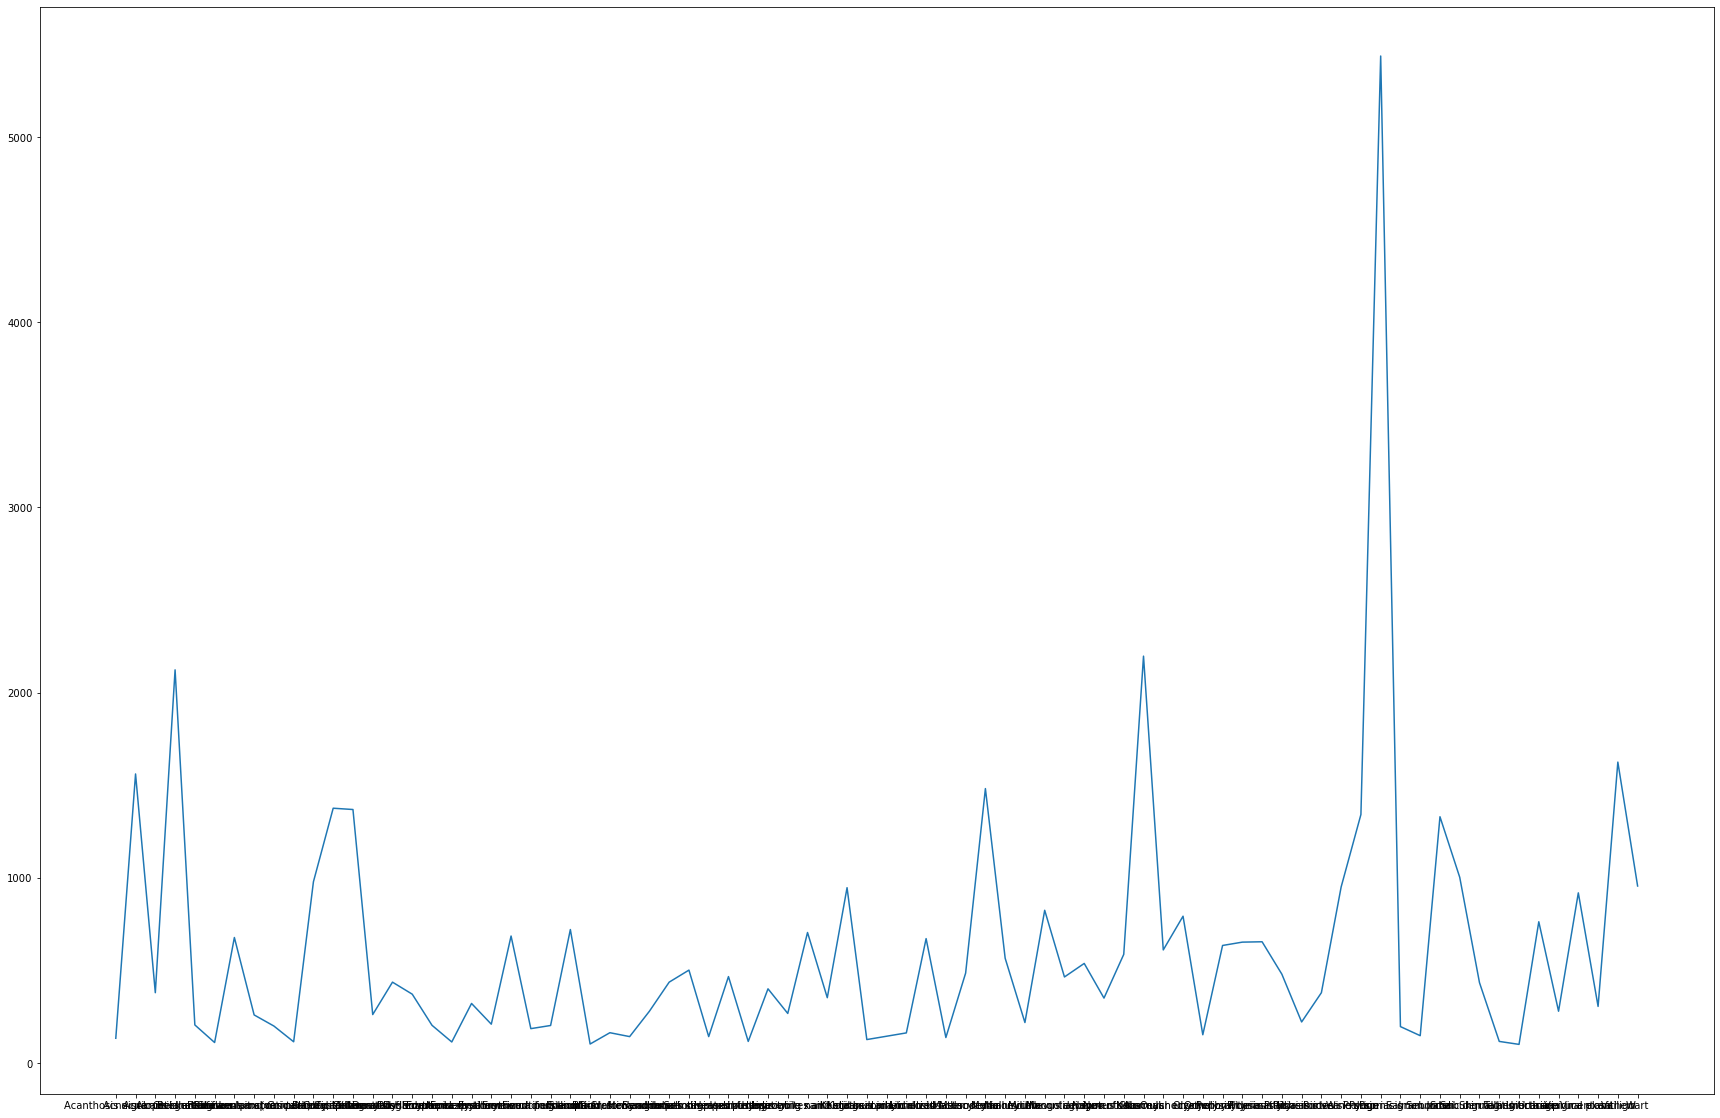

In [7]:
lists = sorted(train_dict.items())
lists

x, y = zip(*lists) 
plt.figure(figsize=(30, 20))
plt.plot(x, y)
plt.show()

In [8]:
N_CLASSES = len(train_dict)

In [9]:
train_images = [] 
test_images = []

for i in range(6):
    for key in train_dict.keys():
        img = glob(dataset + f'/H{str(i)}/{key}/*.jpg')
        train_images.extend(img) 
        
for i in range(7, 10):
    for key in train_dict.keys():
        img = glob(dataset + f'/H{str(i)}/{key}/*.jpg')
        test_images.extend(img) 
        
        
random.shuffle(train_images)
random.shuffle(test_images)
        
len(train_images), len(test_images)
        

(52516, 37369)

In [10]:
label_to_index = {}
for idx, key in zip(range(len(train_dict)), train_dict.keys()):
    label_to_index[key] = idx
    
label_to_index

{'Acne': 0,
 'Acne scar integrated': 1,
 'Alopecia areata': 2,
 'Cafe-au-lait spot': 3,
 'Corn, Callus': 4,
 'Cyst integrated': 5,
 'Dermal Melanocytic Hamartoma': 6,
 'Epidermal nevus': 7,
 'Erythema dyschromicum perstans': 8,
 'Erythema multiforme': 9,
 'Erythema nodosum': 10,
 'Granuloma annulare': 11,
 'Hemangioma integrated': 12,
 'Ichthyosis': 13,
 'Impetigo': 14,
 'Ingrowing nail': 15,
 'Juvenile xanthogranuloma': 16,
 'Keloid scar': 17,
 'Lichen striatus': 18,
 'Localized scleroderma': 19,
 'Mastocytoma': 20,
 'Melanocytic nevus': 21,
 'Melanonychia': 22,
 'Molluscum contagiosum': 23,
 'Mongolian spot': 24,
 'Nevus depigmentosus': 25,
 'Nevus of Ota': 26,
 'Nevus sebaceus': 27,
 'Normal': 28,
 'Nummular eczema': 29,
 'Onychodystrophy': 30,
 'Onycholysis': 31,
 'Perioral dermatitis': 32,
 'Pityriasis alba': 33,
 'Pityriasis lichenoides': 34,
 'Pityriasis versicolor': 35,
 'Port-Wine stain': 36,
 'Prurigo': 37,
 'Psoriasis': 38,
 'Scar': 39,
 'Seborrheic dermatitis': 40,
 'Subung

In [11]:
def train_skin_data(files):
    
    for file in files:
    
        f = file.decode('utf-8')
        
        img = cv2.imread(f, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (N_BEF_RES, N_BEF_RES))
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

        idx = f.split('\\')[1].split('/')[2]
        lbl = tf.keras.utils.to_categorical(label_to_index[idx], len(train_dict))

        yield (img, lbl)    
        
        # if lower than base num, should apply data augmentation
        if base_num <= int(train_dict[idx]):

            # Btight 
            random_bright_tensor = tf.image.random_brightness(img, max_delta=128)
            random_bright_tensor = tf.clip_by_value(random_bright_tensor, 0, 255)
            random_bright_image = tf.keras.preprocessing.image.array_to_img(random_bright_tensor)
            yield (random_bright_tensor, lbl) 
    
            # rotation
            rotated_img = tf.image.rot90(img)        
            yield (rotated_img, lbl) 
            
            # curmix 
            cutmixed_img, cutmixed_lbl = cutmix(img, lbl)
            yield (cutmixed_img, cutmixed_lbl)

        

In [12]:
def test_skin_data(files):
    
    for file in files:
    
        f = file.decode('utf-8')
        
        img = cv2.imread(f, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (N_BEF_RES, N_BEF_RES))
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        
        lbl = tf.keras.utils.to_categorical(label_to_index[f.split('\\')[1].split('/')[2]], len(train_dict))

        yield (img, lbl)    

In [13]:
def cutmix(images, labels):
    # imgs = []; labs = []
    # for i in range(N_BATCH):
    APPLY = tf.cast(tf.random.uniform(()) >= 0.5, tf.int32)
    idx = tf.random.uniform((), 0, len(train_images), tf.int32)
    
    # random_img = 0 
    # random_lbl = 0 
    
    random_img = cv2.imread(train_images[idx], cv2.COLOR_BGR2YCR_CB)
    random_img = cv2.resize(random_img, (N_BEF_RES, N_BEF_RES))
    random_img = cv2.normalize(random_img, None, 0, 255, cv2.NORM_MINMAX)
    random_lbl = tf.keras.utils.to_categorical(label_to_index[train_images[idx].split('\\')[1].split('/')[2]], len(train_dict))

    W = N_RES
    H = N_RES
    lam = tf.random.uniform(())
    cut_ratio = tf.math.sqrt(1.-lam)
    cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY
    cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY

    cx = tf.random.uniform((), int(W/8), int(7/8*W), tf.int32)
    cy = tf.random.uniform((), int(H/8), int(7/8*H), tf.int32)

    xmin = tf.clip_by_value(cx - cut_w//2, 0, W)
    ymin = tf.clip_by_value(cy - cut_h//2, 0, H)
    xmax = tf.clip_by_value(cx + cut_w//2, 0, W)
    ymax = tf.clip_by_value(cy + cut_h//2, 0, H)

    mid_left = images[ymin:ymax, :xmin, :]
    # mid_mid = images[idx, ymin:ymax, xmin:xmax, :]
    mid_mid = random_img[ymin:ymax, xmin:xmax, :]
    mid_right = images[ymin:ymax, xmax:, :]
    middle = tf.concat([mid_left, mid_mid, mid_right], axis=1)
    top = images[:ymin, :, :]
    bottom = images[ymax:, :, :]
    new_img = tf.concat([top, middle, bottom], axis=0)
    # imgs.append(new_img)

    cut_w_mod = xmax - xmin
    cut_h_mod = ymax - ymin
    alpha = tf.cast((cut_w_mod*cut_h_mod)/(W*H), tf.float32)
    # label1 = labels[i]
    label1 = labels
    # label2 = labels[idx]
    label2 = random_lbl
    new_label = ((1-alpha)*label1 + alpha*label2)
    # labs.append(new_label)
        
    # new_imgs = tf.reshape(tf.stack(imgs), [-1, N_RES, N_RES, 3])
    # new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASSES])

    return new_img, new_label

In [14]:
def get_dropout(input_tensor, p=0.3, mc=False):
    if mc: 
        layer = Dropout(p, name='top_dropout')
        return layer(input_tensor, training=True)
    else:
        return Dropout(p, name='top_dropout')(input_tensor, training=False)

In [15]:
def create_class_weight(labels_dict, n_classes=10):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for idx, key in zip(range(N_CLASSES), keys):
        score = total / (n_classes * train_dict[key])
        class_weight[idx] = score
        
    return class_weight
        
class_weights = create_class_weight(train_dict, N_CLASSES)
class_weights

{0: 0.3916867885477751,
 1: 1.609008097165992,
 2: 0.2879995652016377,
 3: 0.9018039482641252,
 4: 0.4443481663685152,
 5: 0.44662021689048714,
 6: 2.333675866118614,
 7: 1.898829431438127,
 8: 2.9115384615384614,
 9: 0.891287284144427,
 10: 3.2872208436724564,
 11: 4.275685852608929,
 12: 1.3991374757965147,
 13: 5.225838264299803,
 14: 1.5247458277383465,
 15: 2.2814293915040182,
 16: 1.7320767051645238,
 17: 0.6456421086832914,
 18: 0.9098557692307693,
 19: 4.4306020066889635,
 20: 1.2580721747388415,
 21: 0.41256617876051077,
 22: 1.0802527860831748,
 23: 0.7411188811188811,
 24: 1.3148883374689826,
 25: 1.136474120674864,
 26: 1.7419460880999342,
 27: 1.0416066046389727,
 28: 0.27829907916389485,
 29: 1.000692433589324,
 30: 0.7710253176835774,
 31: 3.9962292609351433,
 32: 0.9363293674166568,
 33: 0.9334703464474456,
 34: 1.273798076923077,
 35: 1.609008097165992,
 36: 0.6429264741567581,
 37: 0.45560586954029575,
 38: 0.112455964120485,
 39: 0.4597165991902834,
 40: 0.6095942940

In [16]:
def run_expriment(model_name, train_dataset, val_dataset, batch_size=32, mc=False, epochs=100, n_splits=5): 
    
    if model_name == 'efficient':
        # base_model = keras.applications.EfficientNetB0(include_top=False, input_shape=(N_RES, N_RES, 3),  weights = 'imagenet')
        base_model = keras.applications.EfficientNetB7(include_top=False, input_shape=(N_RES, N_RES, 3),  weights = 'imagenet')
        base_model.trainable = True
        
        inputs = keras.Input(shape=(N_RES, N_RES, 3))
        x = base_model(inputs)
        x = keras.layers.GlobalAveragePooling2D()(x) 
        x = get_dropout(x, mc)
        x = keras.layers.Dense(N_CLASSES, activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)
        
    # VGG16 
    else:
        base_model = keras.applications.VGG16(include_top=False, input_shape=(N_RES, N_RES, 3),  weights = 'imagenet')
        base_model.trainable = True
        
        inputs = keras.Input(shape=(N_RES, N_RES, 3))
        x = base_model(inputs)
        x = keras.layers.Flatten(name = "avg_pool")(x) 
        x = keras.layers.Dense(512, activation='relu')(x)
        x = get_dropout(x, mc)
        x = keras.layers.Dense(256, activation='relu')(x)
        x = keras.layers.Dense(N_CLASSES, activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)
        

    sv = [tf.keras.callbacks.ModelCheckpoint(os.path.join(f'models/{model_name}_mc-{str(mc)}_bs-{batch_size}_{time.strftime("%Y%m%d-%H%M%S")}.h5'), 
                                             monitor='val_accuracy', 
                                             verbose=0, 
                                             save_best_only=True,
                                             save_weights_only=True, 
                                             mode='max', 
                                             save_freq='epoch'), 
          tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                           patience = 4, 
                                           min_delta = 0.01)
          ]

    
    LR = 0.0001
    steps_per_epoch = len(train_images) // batch_size
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(LR, steps_per_epoch*30, 0.1, True)
    
    sgd = tf.keras.optimizers.SGD(0.01)
    moving_avg_sgd = tfa.optimizers.MovingAverage(sgd)
    
    model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(), 
                  optimizer = moving_avg_sgd, 
                #   optimizer = tf.keras.optimizers.Adam(lr_schedule), 
                #   optimizer = tf.keras.optimizers.Adam(lr_schedule), 
                  metrics=['accuracy'])
    
    hist = model.fit(train_dataset,
                    validation_data = val_dataset,
                    epochs = epochs,
                    class_weight=class_weights, 
                    verbose = 1,
                    shuffle = True,
                    callbacks = [sv])
    
    # histories.append(hist)
    
    return model, hist
    

In [20]:
# train_dataset = create_dataset(train_images)
# test_dataset = create_dataset(test_images)

train_dataset = tf.data.Dataset.from_generator(train_skin_data, 
                                               output_types=(tf.float64, tf.float32), 
                                               output_shapes=(tf.TensorShape([N_BEF_RES, N_BEF_RES, 3]), tf.TensorShape([N_CLASSES])),
                                               args=[train_images])

test_dataset = tf.data.Dataset.from_generator(test_skin_data, 
                                              output_types=(tf.float64, tf.float32), 
                                              output_shapes=(tf.TensorShape([N_BEF_RES, N_BEF_RES, 3]), tf.TensorShape([N_CLASSES])),
                                              args=[test_images])


In [21]:
split_size = int(len(train_images) * 0.2)
split_train_dataset = train_dataset.skip(split_size)
splot_val_dataset = train_dataset.take(split_size)

In [22]:
with tf.device('/device:GPU:0'):
    model, hist = run_expriment('efficient', split_train_dataset, splot_val_dataset, batch_size=32, mc=True, epochs=100)

Epoch 1/100


ValueError: in user code:

    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\ProgramData\Miniconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(256, 256, 3)


In [23]:
# new_split_train_dataset = split_train_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH).map(cutmix, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
# val_dataset = val_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH).map(cutmix, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
# new_split_train_dataset = split_train_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).prefetch(AUTOTUNE)
# val_dataset = val_dataset.map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).prefetch(AUTOTUNE)

In [70]:
# test_dataset[0][0]test_dataset
# y_pred = model.predict(test_dataset) 
test_dataset = tf.data.Dataset.from_generator(get_skin_data, 
                                            output_types=(tf.float64, tf.float32), 
                                            output_shapes=(tf.TensorShape([224, 224, 3]), tf.TensorShape([N_CLASSES])),
                                            args=[test_images]).batch(64)

# test_dataset
y_pred = model.predict(test_dataset)

InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.
Traceback (most recent call last):

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1047, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.
Traceback (most recent call last):

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1047, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_predict_function_1784584]

InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.
Traceback (most recent call last):

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1047, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.
Traceback (most recent call last):

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1047, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (256, 256, 3) where an element of shape (224, 224, 3) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_predict_function_1784584]

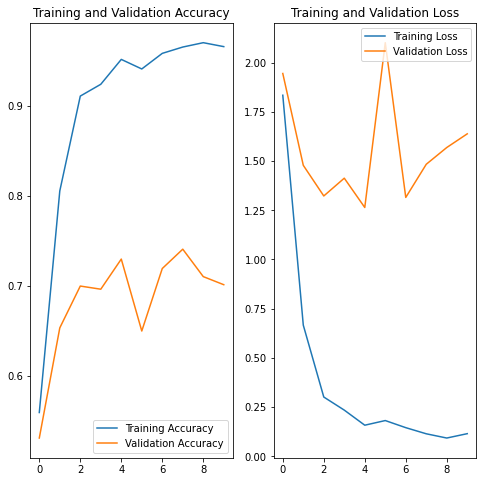

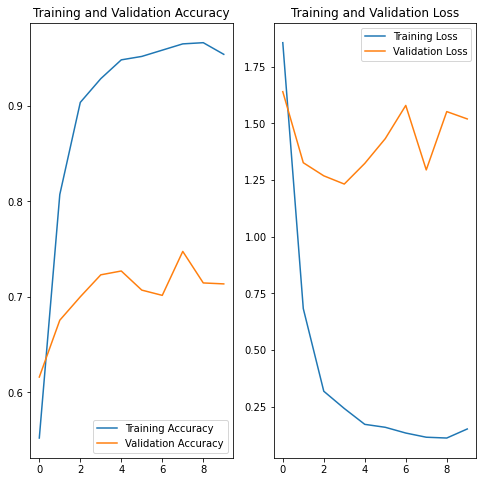

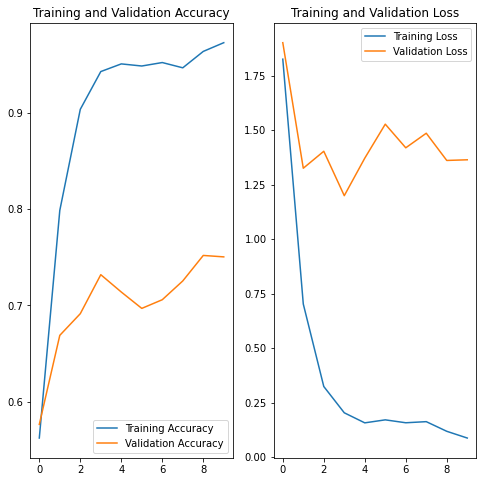

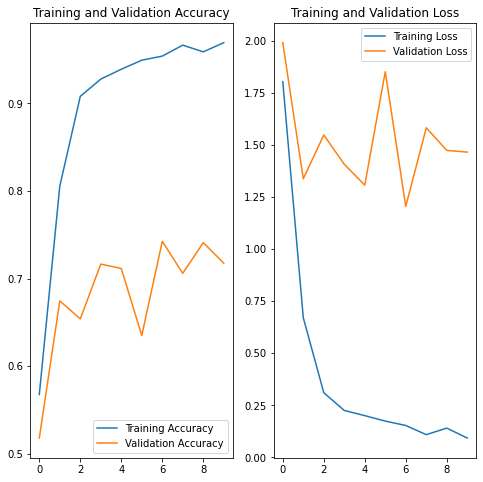

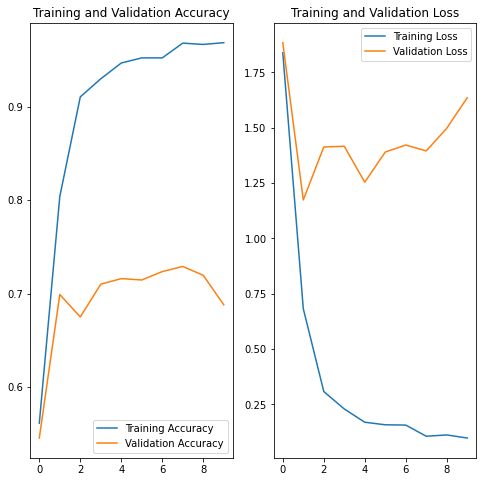

In [30]:
# hist
# for hist in histories:
plt.figure(1, figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()